In [1]:
# L1="0500.HK"
L1="2800.HK"
# L1="^HSI"
start='2007-01-01'
end=None

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf 
import talib as TA
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
#
from findiff import FinDiff
from scipy.signal import find_peaks
import pywt
#
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
#
from various_trading_algo import peak_trough_projection_no_leaking, peak_trough_calculus_projection_no_leaking
from various_trading_algo import strategy, annualised_sharpe, get_kpi_run_strategy

In [3]:
def peak(df,duration):
    peak1=df.rolling(window=duration).max() 
    return(peak1)

def ohlc_gen(stock_code,from1):
    import yfinance as yf
    import talib as TA
    import matplotlib.dates as mdates
    L=[]
    #Fetch daily stock data 
    data = yf.download(stock_code,from1)
    #
    ### Check to make sure they are even number
    if (data.shape[0] % 2) == 1:
        data = data.iloc[1:]
    #
    data["Date"]=data.index
    data["Week"]=data["Date"].dt.week
    data["Year"]=data["Date"].dt.year
    #Create weekly data from daily data
    data_weekly=data[data.index>=from1].groupby(["Year","Week"]).agg(
        {"Date":"first",'Open':'first', 'High':'max', 'Low':'min', 'Close':'last','Volume':'sum'})
    #Add TA in daily and weekly data
    data_weekly["Week"]=data_weekly.index
    data_weekly.index=data_weekly["Date"]
    #
    dayofyear=data['Date'].dt.dayofyear
    data['firstday'] = (dayofyear<dayofyear.shift(1)) | (dayofyear.shift(1).isnull())
    #
    data["EMA9"]=TA.EMA(data["Close"],9)
    data["EMA19"]=TA.EMA(data["Close"],19)
    data["EMA50"]=TA.EMA(data["Close"],50)
    data["RSI9"]=TA.RSI(data["Close"],9)
    data["macd"], data["macdsignal"], data["macdhist"] = TA.MACD(data["Close"], 
                                                           fastperiod=12, 
                                                           slowperiod=26, signalperiod=9)
    #
    data["EMA5"]=TA.EMA(data["Close"],5)
    data["BBupper"], data["BBmid"], data["BBlower"] = TA.BBANDS(data["Close"], 
                                                                timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    data['RSI9-75']=data['RSI9'].rolling(200).apply(lambda x: np.percentile(x, 75))
    data['RSI9-9']=TA.EMA(data["RSI9"],9)
    data['RSI9-19']=TA.EMA(data["RSI9"],19)
    data['RSI9-50']=TA.EMA(data["RSI9"],50)
    data['obv']=TA.OBV(data['Close'], data['Volume'])
    data["obv9"]=TA.EMA(data["obv"],9)
    data["obv19"]=TA.EMA(data["obv"],19)
    data["obv50"]=TA.EMA(data["obv"],50)
    data["chaikin"]=TA.ADOSC(data['High'],data['Low'],data['Close'],data['Volume'], fastperiod=3, slowperiod=10)
    data["chaikin9"]=TA.EMA(data["chaikin"],9)
    data["chaikin19"]=TA.EMA(data["chaikin"],19)
    data["chaikin50"]=TA.EMA(data["chaikin"],50)
    #
    data, _, _, _, _, _ = peak_trough_calculus_projection_no_leaking(data, 'Close')
    data, _, _, _, _, _ = peak_trough_projection_no_leaking(data, 'Close')
    #
    data_weekly["EMA9"]=TA.EMA(data_weekly["Close"],9)
    data_weekly["EMA19"]=TA.EMA(data_weekly["Close"],19)
    data_weekly["EMA50"]=TA.EMA(data_weekly["Close"],50)
    #
    data['Date-simple']=data['Date']
    data["Date"] = data["Date"].apply(mdates.date2num)
    #Construct filtered daily and weekly data for chart generation
    ohlc_col = ['Date', 'Open', 'High', 'Low', 'Close']
    ohlc_rest = list(set(data.columns.tolist()) - set(ohlc_col))
    ohlc_col = ohlc_col + ohlc_rest
    #
    return data, ohlc_col

In [4]:
def candlestick_gen1(label,ohlc_full,start,end,df=None,list_buy=None,list_sell=None,path1=None):
    import matplotlib.pyplot as pl
    %matplotlib inline
    from mpl_finance import candlestick_ohlc
    import matplotlib.dates as mdates
    
    ohlc = ohlc_full.loc[start:end]
    start_date = datetime.strptime(start, '%Y-%m-%d')
    if end is None:
        end_date = datetime.today()
    else:
        end_date = datetime.strptime(end, '%Y-%m-%d')
    fig = plt.figure(figsize = (15,10))
    plt.title(label, loc='left')
    ax1 = plt.subplot2grid((7,4), (0,0), rowspan=3, colspan=4)
    #
    ax1.plot(ohlc["Date"],ohlc["EMA9"],color="blue",label="EMA9",linewidth=1)
    ax1.plot(ohlc["Date"],ohlc["EMA19"],color="red",label="EMA19",linewidth=1)
    ax1.plot(ohlc["Date"],ohlc["EMA50"],color="brown",label="EMA50",linewidth=1)
    '''
    ax1.plot(ohlc["Date"],ohlc["BBupper"],color="blue",label="BB upper",linewidth=1)
    ax1.plot(ohlc["Date"],ohlc["BBmid"],color="red",label="BB middle",linewidth=1)
    ax1.plot(ohlc["Date"],ohlc["BBlower"],color="brown",label="BB lower",linewidth=1)
    '''
    #
    ax1.grid(True)
    candlestick_ohlc(ax1, ohlc.values, width=.4, 
                     colorup='#53c156', colordown='#ff1717')
    
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.legend(["Daily"])
    #
    y_lower = min(ohlc["resist_angle_noleak"].min(), ohlc["resist_angle_noleak"].min()) * 0.9
    y_upper = max(ohlc["support_angle_noleak"].max(), ohlc["support_angle_noleak"].max()) * 1.1
    ax1_angle = plt.subplot2grid((7,4), (3,0), sharex=ax1, rowspan=1, colspan=4)
    ax1_angle.grid(True)
    ax1_angle.set_ylim(y_lower, y_upper)
    ax1_angle.plot(ohlc["Date"],ohlc["resist_angle_noleak"],color="blue",label="resist_angle",linewidth=1)
    ax1_angle.plot(ohlc["Date"],ohlc["support_angle_noleak"],color="red",label="support_angle",linewidth=1)    
    
    ax1_OBV = plt.subplot2grid((7,4), (4,0), sharex=ax1, rowspan=1, colspan=4)
    #ax1_OBV.axes.yaxis.set_ticklabels(["RSI9"])
    ax1_OBV.grid(True)
    '''
    ax1_OBV.set_ylim(0, ohlc["RSI9"].max()+10)
    ax1_OBV.plot(ohlc["Date"].values,ohlc["RSI9"].values,color="red",label="RSI9")    
    ax1_OBV.plot(ohlc["Date"].values,ohlc["RSI9-75"].values,color="black",label="RSI9-75")    

    y_lower = min(ohlc["obv9"].min(), ohlc["obv19"].min()) * 0.5
    y_upper = max(ohlc["obv9"].max(), ohlc["obv19"].max()) * 1.1
    ax1_OBV.set_ylim(y_lower, y_upper)
    ax1_OBV.plot(ohlc["Date"].values,ohlc["obv9"].values,color="blue",label="obv9")
    ax1_OBV.plot(ohlc["Date"].values,ohlc["obv19"].values,color="red",label="obv19")  
    ax1_OBV.plot(ohlc["Date"].values,ohlc["obv50"].values,color="brown",label="obv50")
    '''
    #
    # ax1_OBV2 = ax1_OBV.twinx()
    ax1_OBV.set_ylabel('OBV', color='magenta')
    ax1_OBV.set_ylim(ohlc["obv"].min()*0.5, ohlc["obv"].max()*1.5)
    # ax1_OBV2.bar(ohlc["Date"].values, ohlc["obv"].values)
    ax1_OBV.plot(ohlc["Date"].values,ohlc["obv"].values,color="blue",label="obv")
    #
    ax1_RSI = plt.subplot2grid((7,4), (5,0), sharex=ax1, rowspan=1, colspan=4)
    ax1_RSI.set_ylim(0, ohlc["RSI9"].max()+10)
    ax1_RSI.plot(ohlc["Date"].values,ohlc["RSI9"].values,color="black",label="RSI9")
    ax1_RSI.plot(ohlc["Date"].values,ohlc["RSI9-9"].values,color="blue",label="RSI9-9")
    ax1_RSI.plot(ohlc["Date"].values,ohlc["RSI9-19"].values,color="red",label="RSI9-19")
    ax1_RSI.plot(ohlc["Date"].values,ohlc["RSI9-50"].values,color="brown",label="RSI9-50")
    #ax1_RSI.axhline(50,color="blue",linestyle="--")  
    ax1_RSI.grid(True)
    #    
    ax1v = plt.subplot2grid((7,4), (6,0), sharex=ax1, rowspan=1, colspan=4)
    ax1v.axes.yaxis.set_ticklabels(["Volume"])
    ax1v.grid(False)
    ax1v.set_ylim(0, ohlc["Volume"].max())
    ax1v.bar(ohlc["Date"].values,ohlc["Volume"].values)
    #
    ax1_chai = plt.subplot2grid((6,4), (4,0), sharex=ax1, rowspan=1, colspan=4)
    ax1_chai.plot(ohlc["Date"].values,ohlc["chaikin"].values,color="magenta",label="Chaikin A/D")
    ax1_chai.axhline(0,color="black",linestyle="--") 
    # ax1_chai.plot(ohlc["Date"].values,ohlc["chaikin3"].values,color="blue",label="Chaikin SMA 3")
    # ax1_chai.plot(ohlc["Date"].values,ohlc["chaikin5"].values,color="red",label="Chaikin SMA 5")
    # ax1_chai.plot(ohlc["Date"].values,ohlc["chaikin7"].values,color="brown",label="Chaikin SMA 7")
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1_OBV.get_xticklabels(), visible=False)


    plt.subplots_adjust(hspace=0)
    
    ax1.legend(loc="upper left")
    ax1_angle.legend(loc="upper left")
    ax1_OBV.legend(loc="upper right")
    ax1_RSI.legend(loc="upper right")
    ax1_chai.legend(loc="upper right")
    
    for d in ohlc['firstday'][ohlc['firstday']].index:
        ax1.axvline(d,color="black",linestyle="-")
    
    if list_buy is not None:
        if len(list_buy)>0:
            list_buy1=[i for i in list_buy if ((i>=start_date) & (i<=end_date))]
            for x1 in list_buy1:
                ax1.axvline(x1,color="blue",linestyle="--")
        
    if list_sell is not None:
        if len(list_sell)>0:
            list_sell1=[i for i in list_sell if ((i>=start_date) & (i<=end_date))]
            for x1 in list_sell1:
                ax1.axvline(x1,color="red",linestyle="--")
    
    for i, v in ohlc['peak_noleak'][ohlc['peak_noleak']].items():
        ax1.scatter(i, ohlc.loc[i, 'Close'], marker="^", s=100)
    for i, v in ohlc['trough_noleak'][ohlc['trough_noleak']].items(): 
        ax1.scatter(i, ohlc.loc[i, 'Close'], marker="v",s=100)    

    if path1 is not None:
        plt.savefig(path1)

    plt.show()    

In [5]:
def peak_trough_projection_pymt_and_scipy(data, TA):
    # Wrong algo - because some information is leaked to future when determining peak and trough
    # remove the same consecutive values in data[TA]
    temp = data[TA].copy()
    # temp_next=temp.shift(-1)
    no_redund = pd.DataFrame(temp)
    #
    # Clean up with pyw
    Close_raw = no_redund[TA]
    x = Close_raw.values # x is np array               
    (ca, cd) = pywt.dwt(x, "haar")                
    cat = pywt.threshold(ca, np.std(ca), mode="soft")                
    cdt = pywt.threshold(cd, np.std(cd), mode="soft")                
    tx = pywt.idwt(cat, cdt, "haar")
    #
    Close_pywt = pd.Series(tx, index=Close_raw.index)
    #
    # Find support and resistance using scipy
    peaks2, _ = find_peaks(Close_pywt, prominence=1)
    peak = pd.Series(False, index=no_redund.index)
    peak.iloc[peaks2]=True
    #
    Negative_pywt = Close_pywt * -1.0
    troughs2, _ = find_peaks(Negative_pywt, prominence=1)
    trough = pd.Series(False, index=no_redund.index)
    trough.iloc[troughs2]=True    
    
    peak_only = peak[peak]
    trough_only = trough[trough]
    #
    base_date = data.index[0]
    x_axis = pd.Series(data.index.map(lambda date : (pd.Timestamp(date) - base_date).days) + 1, index=data.index)
    x_range = x_axis[-1] - x_axis[0]
    y_axis = data[TA]
    y_range = y_axis[-1] - y_axis[0]
    #
    degree = 1
    resistance, resist_angle, model_peak, prev_high = projection_from_last_few_points(data, peak_only, x_axis, y_axis, degree, x_range, y_range)
    support, support_angle, model_trough, prev_low = projection_from_last_few_points(data, trough_only, x_axis, y_axis, degree, x_range, y_range)
    return x_axis, resistance, resist_angle, peak, model_peak, support, support_angle, trough, model_trough, \
           prev_high, prev_low

In [6]:
#df=yf.download(L1,'2017-01-01')
data_start = datetime.strptime(start, '%Y-%m-%d')
one_year_before = data_start + relativedelta(years=-1)
print('y_finance load date : {}'.format(one_year_before))
#
data, ohlc_col=ohlc_gen(L1,one_year_before.strftime('%Y-%m-%d'))

y_finance load date : 2006-01-01 00:00:00
[*********************100%***********************]  1 of 1 completed


/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

/home/keithyamkf/jupyter-notebook/python-trading/backtesting/various_trading_algo.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['resist_calculus'] = resistance
/home/keithyamkf/jupyter-notebook/python-trading/backtesting/various_trading_algo.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['resist_angle_calculus'] = resist_angle
/home/keithyamkf/jupyter-notebook/python-trading/backtesting/various_trading_algo.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


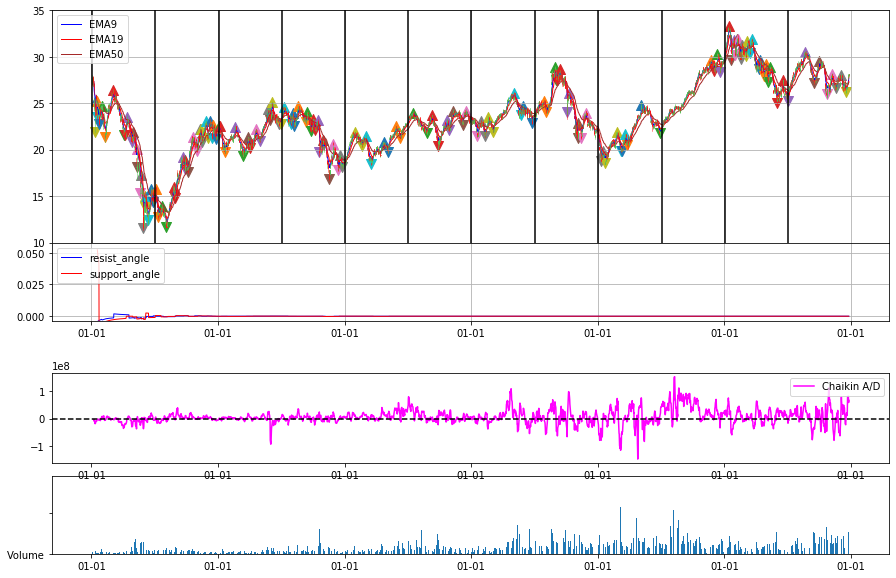

In [7]:
candlestick_gen1(L1,data.loc[start:end, ohlc_col],start,end,None,None,None,"fig3.png")

In [8]:
data1=data.loc[start:end].copy()

In [9]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2944 entries, 2008-01-02 to 2019-12-20
Data columns (total 50 columns):
Open                      2944 non-null float64
High                      2944 non-null float64
Low                       2944 non-null float64
Close                     2944 non-null float64
Adj Close                 2944 non-null float64
Volume                    2944 non-null int64
Date                      2944 non-null float64
Week                      2944 non-null int64
Year                      2944 non-null int64
firstday                  2944 non-null bool
EMA9                      2936 non-null float64
EMA19                     2926 non-null float64
EMA50                     2895 non-null float64
RSI9                      2935 non-null float64
macd                      2911 non-null float64
macdsignal                2911 non-null float64
macdhist                  2911 non-null float64
EMA5                      2940 non-null float64
BBupper             

# Backtesting

In [10]:
def cross_over_up(param):
    df,TA1,TA2=param
    condition = (df[TA1]>df[TA2])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_3(param):
    df,TA1,TA2,TA3=param
    condition = (df[TA1]>df[TA2]) & (df[TA3]<0)
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_2pairs(param):
    df,TA1,TA2,TA3,TA4=param
    condition = (df[TA1]>df[TA2]) & (df[TA3]>df[TA4])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up1(param):
    df,TA1,TA2,TA3 = param
    TA1_TA2=np.where((df[TA1]>df[TA2]) & (df[TA2]>df[TA3]),1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up2(param):
    df,TA1,TA2,TA3,TA4,TA5 = param
    condition = (df[TA1]>df[TA2]) & (df[TA3]>df[TA4]) & (df[TA4]>df[TA5])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_doji_2(param):
    df,TA1,TA2 = param
    df_doji=TA.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
    condition = (df[TA1]>df[TA2]) & (df_doji > 0)
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_doji_morning_2(param):
    df,TA1,TA2 = param
    df_doji=TA.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
    df_morning=TA.CDLMORNINGDOJISTAR(df["Open"], df["High"], df["Low"], df["Close"])
    condition = (df[TA1]>df[TA2]) & ((df_doji > 0) | (df_morning > 0))
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_doji_morning_4(param):
    df,TA1,TA2,TA3,TA4 = param
    df_doji=TA.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
    df_morning=TA.CDLMORNINGDOJISTAR(df["Open"], df["High"], df["Low"], df["Close"])
    condition = (df[TA1]>df[TA2]) & (df[TA3]>df[TA4]) & ((df_doji > 0) | (df_morning > 0))
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_doji_3(param):
    df,TA1,TA2,TA3 = param
    df_doji=TA.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
    condition = (df[TA1]>df[TA2]) & (df[TA2]>df[TA3]) & (df_doji > 0)
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up4(param):
    df,TA1,TA2,TA3,TA4,TA5 = param
    condition = (df[TA1]>df[TA2]) & (df[TA2]>df[TA3]) & (df[TA4]<df[TA5])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_BBmid_RSI(param):
    df,TA1,TA2,TA3,TA4,TA5,TA6,TA7,TA8 = param
    # Close and High > BBmid + RSI > 50 + OBV-SMA9 > OBV-SMA19
    condition = (df[TA1]>df[TA3]) & (df[TA2]>df[TA3]) & (df[TA4]>50) & (df[TA4]<70) & (df[TA6]>df[TA7]) & (df[TA7]>df[TA8])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_BBmid_RSI1(param):
    df,TA1,TA2,TA3,TA4,TA5,TA6,TA7,TA8,TA9,TA10 = param 
    # Close and High > BBmid + RSI < 50 + RSI9-9 > RSI9-19 > RSI9-50 
    # OBV-SMA9 > OBV-SMA19 > OBV-SMA50
    condition = (df[TA1]>df[TA3]) & (df[TA2]>df[TA3]) & \
                (df[TA5]>df[TA6]) & (df[TA6]>df[TA7]) & \
                (df[TA8]>df[TA9]) & (df[TA9]>df[TA10])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

In [11]:
def cross_over_down(param):
    df,TA1,TA2 = param
    TA1_TA2=np.where((df[TA1]-df[TA2])<0,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_down_BB_EMA(param):
    df,TA1,TA2,TA3,TA4,TA5 = param
    condition = (df[TA1]<df[TA2]) & (df[TA3]<df[TA4])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

In [12]:
def enter_augment_none(param):
    return True

def augment_cross_over(param):
    df,TA1,TA2 = param
    return df[TA1]>df[TA2]

In [13]:
def stoploss(df,enter,threshold,long):
    Stop_loss_threshold=pd.Series(np.where((enter==1),df["Open"]*threshold,0), index=enter.index)
    Stop_loss_threshold.replace(to_replace=0, method='ffill',inplace=True)
    if long==1:
        stop_loss=np.where((Stop_loss_threshold>=df["Close"]),1,0)
    else:
        stop_loss=np.where((Stop_loss_threshold<=df["Close"]),1,0)
    return(stop_loss)

## EMA cross over strategy

In [14]:
# param = (data1,"macd","macdsignal")
# enter=cross_over_up(param)
# param = (data1,"EMA5","BBmid")
# enter=cross_over_up(param)
param = (data1,"Close","resist_noleak")
enter=cross_over_up(param)
# param = (data1,"Close","resist_calculus","resist_angle_calculus")
# enter=cross_over_up_3(param)
# param = (data1,"Close","resist_noleak")
# enter=cross_over_up(param)
# param = (data1,"Close","prev_high_scipy")
# enter=cross_over_up(param)
# param = (data1,"Close","resist_scipy","resist_angle_scipy")
# enter=cross_over_up_3(param)
# param = (data1,"EMA5","BBmid","EMA9","EMA50")
# enter=cross_over_up_2pairs(param)
# param = (data1,"obv9","obv19","obv50")
# enter=cross_over_up1(param)
# param=(data1,"EMA9","EMA19","EMA50")
# enter=cross_over_up1(param)
# param = (data1,"macd","macdsignal","EMA9","EMA19","EMA50")
# enter=cross_over_up2(param)
# param = (data1,"EMA5","BBmid")
# enter=cross_over_up_doji_2(param)
# param = (data1,"EMA5","BBmid")
# enter=cross_over_up_doji_morning_2(param)
# param = (data1,"EMA5","BBmid","EMA9","EMA50")
# enter=cross_over_up_doji_morning_4(param)
# param = (data1,"EMA9","EMA19","EMA50")
# enter=cross_over_up_doji_3(param)
# param = data1,"EMA9","EMA19","EMA50","RSI9","RSI9-75"
# enter=cross_over_up4(param)
# param = (data1,'Close','High','BBmid','RSI9','RSI9-75','obv9','obv19','obv50')
# enter=cross_over_up_BBmid_RSI(param)
# Close and High > BBmid + RSI > 50 + OBV-SMA9 > OBV-SMA19
# param = (data1,'Close','High','BBmid','RSI9','RSI9-9','RSI9-19','RSI9-50','obv9','obv19','obv50')
# enter=cross_over_up_BBmid_RSI1(param)
    # Close and High > BBmid + RSI < 50 + RSI9-9 > RSI9-19 > RSI9-50 
    # OBV-SMA9 > OBV-SMA19 > OBV-SMA50

param = (data1,"EMA9","EMA19")
exit=cross_over_down(param)
param = (data1,"Low","BBlower")
exit1=cross_over_down(param)
param = (data1,"Low","BBlower","EMA9","EMA19","EMA50")
exit3=cross_over_down_BB_EMA(param)

### Display enter and exit

In [15]:
print(enter[enter==1].index.astype(str))
print(exit[exit==1].index.astype(str))

Index(['2008-04-02', '2008-11-05', '2008-11-10', '2008-12-08', '2009-03-13',
       '2009-05-04', '2009-05-15', '2009-07-15', '2009-10-14', '2010-01-05',
       '2010-07-21', '2010-10-06', '2011-04-01', '2011-07-22', '2011-07-26',
       '2011-09-16', '2011-10-11', '2012-01-03', '2012-09-12', '2013-09-05',
       '2014-04-01', '2014-07-23', '2014-11-24', '2014-12-04', '2014-12-10',
       '2014-12-22', '2015-04-01', '2015-09-30', '2016-02-15', '2016-07-04',
       '2016-07-12', '2017-11-22', '2018-01-08', '2018-03-09', '2018-05-08',
       '2018-08-08', '2018-08-21', '2019-01-11', '2019-01-15', '2019-10-17',
       '2019-11-01', '2019-12-17'],
      dtype='object')
Index(['2008-01-28', '2008-05-26', '2008-08-08', '2009-01-12', '2009-07-08',
       '2009-08-31', '2009-10-05', '2009-11-03', '2009-11-27', '2009-12-09',
       '2010-01-18', '2010-04-27', '2010-07-07', '2010-08-24', '2010-11-18',
       '2011-02-01', '2011-03-15', '2011-05-04', '2011-06-07', '2011-07-12',
       '2011-08-04

### Test a ENTER strategy with additional stringent criteria 

In [16]:
enter1 = (enter==1) & (data1['EMA9']>data1['EMA50'])
enter1[enter1==1].index.astype(str)

Index(['2009-05-04', '2009-05-15', '2009-07-15', '2009-10-14', '2010-07-21',
       '2010-10-06', '2011-04-01', '2012-09-12', '2013-09-05', '2014-07-23',
       '2015-04-01', '2016-07-04', '2016-07-12', '2017-11-22', '2018-01-08',
       '2019-01-15', '2019-11-01', '2019-12-17'],
      dtype='object')

In [17]:
# exit1[exit1==1].index.astype(str).tolist()
exit2=(exit[exit==1]) | (exit1[exit1==1])

In [18]:
df=strategy(data1,enter,exit1,["RSI9","RSI9-75"],1,0.9,stoploss_needed=True)
df.style.format({
    'Return': '{:,.2%}'.format
})
df

,Date_Buy,Date_Sell,Price_Buy,Price_Sell,Sell_cos_stoploss,RSI9,RSI9-75,Gain,Return,Position
Date_Buy,,,,,,,,,,
2008-04-03,2008-04-03,2008-05-02,24.100000,26.450001,False,66.394565,NaN,2.350000,9.751039,long
2008-11-06,2008-11-06,2008-11-10,14.200000,15.080000,False,42.450281,NaN,0.880000,6.197184,long
2008-11-11,2008-11-11,2008-11-14,14.360000,13.880000,False,45.595299,51.537760,-0.480000,-3.342615,long
2008-12-09,2008-12-09,2008-12-15,15.000000,15.400000,False,65.438649,52.114738,0.400000,2.666664,long
2009-03-16,2009-03-16,2009-04-21,12.760000,15.340000,False,61.367363,48.074595,2.580000,20.219435,long
2009-05-05,2009-05-05,2009-05-15,16.540001,16.980000,False,70.111692,56.930241,0.439999,2.660209,long
2009-05-18,2009-05-18,2009-05-19,16.600000,17.500000,False,63.150337,58.677064,0.900000,5.421684,long
2009-07-16,2009-07-16,2009-08-07,19.000000,21.100000,False,58.765722,61.062723,2.100000,11.052634,long
2009-10-15,2009-10-15,2009-10-28,22.600000,22.650000,False,67.935117,67.113410,0.049999,0.221236,long


### Specify period of transaction

In [19]:
print(df[df['Gain']>0].shape)
df[(df['Gain']>0) & (df["RSI9"]<df["RSI9-75"])].shape

(26, 10)


(10, 10)

In [20]:
print(df[df['Gain']<=0].shape)
df[(df['Gain']<=0) & (df["RSI9"]<df["RSI9-75"])].shape

(11, 10)


(10, 10)

In [21]:
df

,Date_Buy,Date_Sell,Price_Buy,Price_Sell,Sell_cos_stoploss,RSI9,RSI9-75,Gain,Return,Position
Date_Buy,,,,,,,,,,
2008-04-03,2008-04-03,2008-05-02,24.100000,26.450001,False,66.394565,NaN,2.350000,9.751039,long
2008-11-06,2008-11-06,2008-11-10,14.200000,15.080000,False,42.450281,NaN,0.880000,6.197184,long
2008-11-11,2008-11-11,2008-11-14,14.360000,13.880000,False,45.595299,51.537760,-0.480000,-3.342615,long
2008-12-09,2008-12-09,2008-12-15,15.000000,15.400000,False,65.438649,52.114738,0.400000,2.666664,long
2009-03-16,2009-03-16,2009-04-21,12.760000,15.340000,False,61.367363,48.074595,2.580000,20.219435,long
2009-05-05,2009-05-05,2009-05-15,16.540001,16.980000,False,70.111692,56.930241,0.439999,2.660209,long
2009-05-18,2009-05-18,2009-05-19,16.600000,17.500000,False,63.150337,58.677064,0.900000,5.421684,long
2009-07-16,2009-07-16,2009-08-07,19.000000,21.100000,False,58.765722,61.062723,2.100000,11.052634,long
2009-10-15,2009-10-15,2009-10-28,22.600000,22.650000,False,67.935117,67.113410,0.049999,0.221236,long


In [22]:
tran_start = '2008-01-01'
tran_end = '2008-12-31'
df.loc[tran_start:tran_end]

,Date_Buy,Date_Sell,Price_Buy,Price_Sell,Sell_cos_stoploss,RSI9,RSI9-75,Gain,Return,Position
Date_Buy,,,,,,,,,,
2008-04-03,2008-04-03,2008-05-02,24.10,26.450001,False,66.394565,NaN,2.35,9.751039,long
2008-11-06,2008-11-06,2008-11-10,14.20,15.080000,False,42.450281,NaN,0.88,6.197184,long
2008-11-11,2008-11-11,2008-11-14,14.36,13.880000,False,45.595299,51.537760,-0.48,-3.342615,long
2008-12-09,2008-12-09,2008-12-15,15.00,15.400000,False,65.438649,52.114738,0.40,2.666664,long


### Display signal in the buy date

In [23]:
pd.options.display.float_format = '{:.2f}'.format
data1.loc[df.index, ['EMA9', 'EMA50']]
# data1.loc[df.index, ['RSI9']]

,EMA9,EMA50
Date_Buy,,
2008-04-03,23.46,23.92
2008-11-06,14.22,17.07
2008-11-11,14.33,16.77
2008-12-09,14.19,15.07
2009-03-16,12.49,13.25
2009-05-05,15.72,14.59
2009-05-18,16.88,15.35
2009-07-16,18.32,17.77
2009-10-15,21.97,21.12


In [24]:
buy_list=df.index.tolist()

In [25]:
sell_list=df["Date_Sell"].tolist()

In [26]:
#sell_list=df["Date_Sell"].dt.strftime("%Y-%m-%d").tolist()

### Calculate GAIN

In [27]:
df_sum=df.copy()

In [28]:
GAIN=[]
for i in data1.index:
    if i in list(df_sum.index):
        result=df_sum.loc[i]["Gain"]
    else:
        result=0
    GAIN.append(result)
GAIN_df=pd.Series(GAIN,index=data1.index)     

In [29]:
GAIN_df.dropna().cumsum()[-1]

19.360005378723145

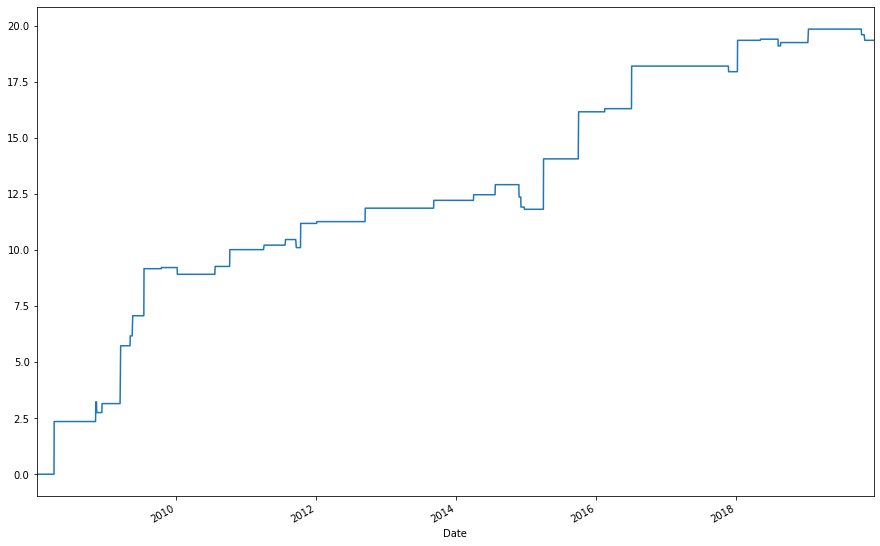

In [30]:
GAIN_df.dropna().cumsum().plot(figsize=(15,10))

### Define Start and End date

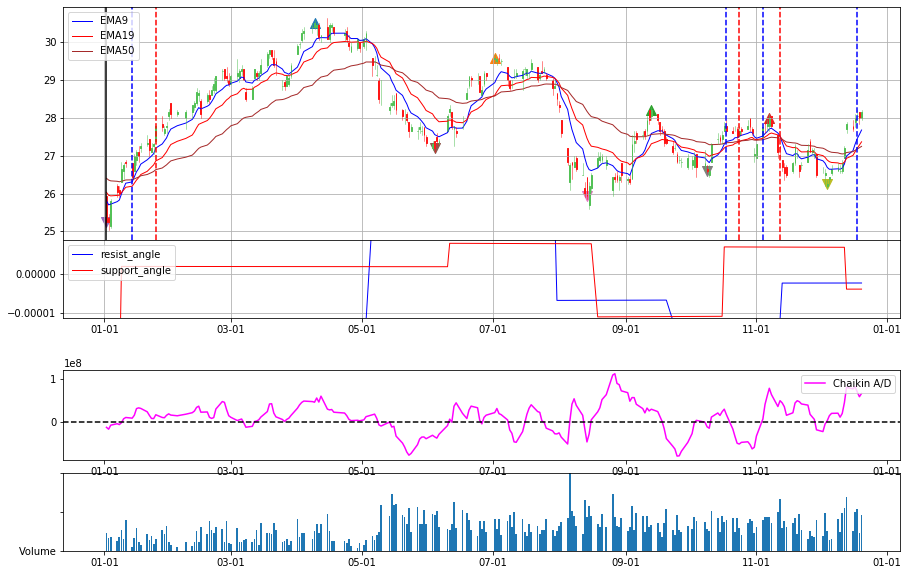

In [31]:
start_chart='2019-01-01'
end_chart=None
#
candlestick_gen1(L1,data.loc[start:end, ohlc_col],start_chart,end_chart,data.loc[start:end],buy_list,sell_list,"fig1.png")

### Calculate Sharpe ratio

In [32]:
annualised_sharpe(df['Return'])

8.854916264592172

### Compare each algorithm

In [54]:
functions_dict = {
    'cross_over_up_macd' : cross_over_up,
    'cross_over_up_BB' : cross_over_up,
    'cross_over_up_resist_calculus' : cross_over_up_3,
    'cross_over_up_support_calculus' : cross_over_up,
    'cross_over_up_resist_noleak_3' : cross_over_up_3,
    'cross_over_up_resist_noleak' : cross_over_up,
    'cross_over_up_support_noleak' : cross_over_up,
    'cross_over_up1_obv' : cross_over_up1,
    'cross_over_up1_EMA' : cross_over_up1,
    'cross_over_up2' : cross_over_up2,
    'cross_over_up_doji_2' : cross_over_up_doji_2,
    'cross_over_up_doji_morning_2' : cross_over_up_doji_morning_2,
    'cross_over_up_doji_3' : cross_over_up_doji_3,
    'cross_over_up4' : cross_over_up4,
    'cross_over_up_BBmid_RSI' : cross_over_up_BBmid_RSI,
    'cross_over_up_BBmid_RSI1' : cross_over_up_BBmid_RSI1,
}
params_dict = {
    'cross_over_up_macd' : (data1,"macd","macdsignal"),
    'cross_over_up_BB' : (data1,"EMA5","BBmid"),
    'cross_over_up_resist_calculus' : (data1,"Close","resist_calculus","resist_angle_calculus"),
    'cross_over_up_support_calculus' : (data1,"Close","support_calculus"),
    'cross_over_up_resist_noleak_3' : (data1,"Close","resist_noleak","resist_angle_noleak"),
    'cross_over_up_resist_noleak' : (data1,"Close","resist_noleak"),
    'cross_over_up_support_noleak' : (data1,"Close","support_noleak"),
    'cross_over_up1_obv' : (data1,"obv9","obv19","obv50"),
    'cross_over_up1_EMA' : (data1,"EMA9","EMA19","EMA50"),
    'cross_over_up2' : (data1,"macd","macdsignal","EMA9","EMA19","EMA50"),
    'cross_over_up_doji_2' : (data1,"EMA5","BBmid"),
    'cross_over_up_doji_morning_2' : (data1,"EMA5","BBmid"),
    'cross_over_up_doji_3' : (data1,"EMA9","EMA19","EMA50"),
    'cross_over_up4' : (data1,"EMA9","EMA19","EMA50","RSI9","RSI9-75"),
    'cross_over_up_BBmid_RSI' : (data1,'Close','High','BBmid','RSI9','RSI9-75','obv9','obv19','obv50'),
    'cross_over_up_BBmid_RSI1' : (data1,'Close','High','BBmid','RSI9','RSI9-9','RSI9-19','RSI9-50','obv9','obv19','obv50'),
}
enter_augment_dict = {
    'no_augment' : enter_augment_none,
    'augment_cross_over_EMA_9_50' : augment_cross_over
}
enter_augment_param_dict = {
    'no_augment' : None,
    'augment_cross_over_EMA_9_50' : (data1,'EMA9','EMA50')
}

exit_dict = {
    'cross_over_down_EMA9_EMA19' : cross_over_down,
    'cross_over_down_Low_BBlower' : cross_over_down,
    'cross_over_down_BB_EMA' : cross_over_down_BB_EMA,
}
exit_prem_dict = {
    'cross_over_down_EMA9_EMA19' : (data1,"EMA9","EMA19"),
    'cross_over_down_Low_BBlower' : (data1,"Low","BBlower"),
    'cross_over_down_BB_EMA' : (data1,"Low","BBlower","EMA9","EMA19","EMA50"),
}

start_time = datetime.now()

# kpi = dict()
algokpi_list = list()
for k_enter, func_enter in functions_dict.items():
    enter_cp = func_enter(params_dict[k_enter])
    for k_augm, func_augm in enter_augment_dict.items():
        augm_cp = func_augm(enter_augment_param_dict[k_augm])
        for k_exit, func_exit in exit_dict.items():
            exit_cp = func_exit(exit_prem_dict[k_exit])
            enter_augcp = (enter_cp==1) & augm_cp
            #
            for stoploss_needed in [True, False]:
                input_dict = {
                    'enter' : enter_augcp,
                    'exit' : exit_cp,
                    'stoploss_needed' : stoploss_needed,
                    'k_enter' : k_enter,
                    'k_augm' : k_augm,
                    'k_exit' : k_exit
                }
                algokpi_list.append(input_dict)
#
parallel = True
if parallel:
    cpu = cpu_count()
    # cpu = 4
    print('cpu_count {}'.format(cpu))
    executor = Parallel(n_jobs=cpu, backend='multiprocessing')
    tasks = (delayed(get_kpi_run_strategy)(data1, input_dict) for input_dict in algokpi_list)
    algokpi_list = executor(tasks)
else:
    algokpi_list = [get_kpi_run_strategy(data1, input_dict) for input_dict in algokpi_list]
algokpi_df = pd.DataFrame(algokpi_list)
#            
print('Duration = {}'.format(datetime.now() - start_time))

cpu_count 8
Duration = 0:01:52.621661


In [55]:
algokpi_df.sort_values(by='sharpe_ratio', ascending=False)

,augment,enter,exit,kpi,sharpe_ratio,stoploss_needed
69,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak,cross_over_down_Low_BBlower,11.74,14.80,False
68,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak,cross_over_down_Low_BBlower,11.74,14.80,True
56,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak_3,cross_over_down_Low_BBlower,5.75,12.98,True
57,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak_3,cross_over_down_Low_BBlower,5.75,12.98,False
59,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak_3,cross_over_down_BB_EMA,7.40,10.29,False
58,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak_3,cross_over_down_BB_EMA,7.40,10.29,True
54,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak_3,cross_over_down_EMA9_EMA19,6.15,10.14,True
55,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak_3,cross_over_down_EMA9_EMA19,6.15,10.14,False
63,no_augment,cross_over_up_resist_noleak,cross_over_down_Low_BBlower,19.36,8.85,False
62,no_augment,cross_over_up_resist_noleak,cross_over_down_Low_BBlower,19.36,8.85,True


In [56]:
algokpi_df[algokpi_df['sharpe_ratio']>8].sort_values(by='kpi', ascending=False)

,augment,enter,exit,kpi,sharpe_ratio,stoploss_needed
62,no_augment,cross_over_up_resist_noleak,cross_over_down_Low_BBlower,19.36,8.85,True
63,no_augment,cross_over_up_resist_noleak,cross_over_down_Low_BBlower,19.36,8.85,False
68,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak,cross_over_down_Low_BBlower,11.74,14.80,True
69,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak,cross_over_down_Low_BBlower,11.74,14.80,False
58,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak_3,cross_over_down_BB_EMA,7.40,10.29,True
59,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak_3,cross_over_down_BB_EMA,7.40,10.29,False
54,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak_3,cross_over_down_EMA9_EMA19,6.15,10.14,True
55,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak_3,cross_over_down_EMA9_EMA19,6.15,10.14,False
56,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak_3,cross_over_down_Low_BBlower,5.75,12.98,True
57,augment_cross_over_EMA_9_50,cross_over_up_resist_noleak_3,cross_over_down_Low_BBlower,5.75,12.98,False


### Test getattr

In [57]:
functions_dict = {'cross_over_up1': cross_over_up1}
params_dict = {'cross_over_up1': (data1,"EMA9","EMA19","EMA50")}

mystring = 'cross_over_up1'
if mystring in functions_dict:
    print(functions_dict[mystring](params_dict[mystring]))
    

2008-01-02    0
2008-01-03    0
2008-01-04    0
2008-01-07    0
2008-01-08    0
2008-01-09    0
2008-01-10    0
2008-01-11    0
2008-01-14    0
2008-01-15    0
2008-01-16    0
2008-01-17    0
2008-01-18    0
2008-01-21    0
2008-01-22    0
2008-01-23    0
2008-01-24    0
2008-01-25    0
2008-01-28    0
2008-01-29    0
2008-01-30    0
2008-01-31    0
2008-02-01    0
2008-02-04    0
2008-02-05    0
2008-02-06    0
2008-02-11    0
2008-02-12    0
2008-02-13    0
2008-02-14    0
             ..
2019-11-11    0
2019-11-12    0
2019-11-13    0
2019-11-14    0
2019-11-15    0
2019-11-18    0
2019-11-19    0
2019-11-20    0
2019-11-21    0
2019-11-22    0
2019-11-25    0
2019-11-26    0
2019-11-27    0
2019-11-28    0
2019-11-29    0
2019-12-02    0
2019-12-03    0
2019-12-04    0
2019-12-05    0
2019-12-06    0
2019-12-09    0
2019-12-10    0
2019-12-11    0
2019-12-12    0
2019-12-13    0
2019-12-16    0
2019-12-17    0
2019-12-18    1
2019-12-19    0
2019-12-20    0
Length: 2944, dtype: int

In [58]:
data2 = data.copy()

In [59]:
data2['year'] = data2['Date-simple'].dt.year

In [60]:
np.mean(data2.groupby('year')['Open'].count())

245.33333333333334